## 0. 개선사항

- 조금 더 많은 데이터가 필요하다. (문장별 분할 필요 x)

## 1. 필요 패키지 설치
- 실행이 안될 경우만 설치할 것!!
- 중복 설치시 패키지 충돌로 오류발생 가능성 있음.

## 2. 패키지 로드

In [1]:
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast # 사전 훈련된 토크나이저 및 모델 로드 (torch 형 모델)

# fastai란?
# Pytorch의 상위 wrapper
# Pytorch를 한번 더 감싸서 많은 것들을 자동화 시켜주고 모델러들이 핵심(데이터)에 집중할 수 있도록 하는 것을 목
from fastai.text.all import * 
import fastai
import re

# 패키지 버전 확인
print(torch.__version__)
print(transformers.__version__)
print( fastai.__version__)

1.9.1+cu102
4.20.1
2.4


In [2]:
# pre-trained 토크나이저, 모델 로드
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",bos_token='</s>', eos_token='</s>', unk_token='<unk>',
                                                    pad_token='<pad>', mask_token='<mask>') 
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/transformers/models/auto/modeling_auto.py:969: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


## 3. 로드 모델 및 토크나이저 TEST

In [3]:
# Test
#test tokenizer
print(tokenizer.tokenize("안녕하세요. 한국어 GPT-2 입니다.😤:)l^o"))

#test model ouput
text = """위치추적 전자장치(전자발찌) 훼손 전후로 여성 2명을 잇달아 살해한 """
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=128,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True
                        )
generated = tokenizer.decode(gen_ids[0,:].tolist())
print(generated)

['▁안녕', '하', '세', '요.', '▁한국어', '▁G', 'P', 'T', '-2', '▁입', '니다.', '😤', ':)', 'l^o']
위치추적 전자장치(전자발찌) 훼손 전후로 여성 2명을 잇달아 살해한 ᄋ씨(33)에 대해 구속영장을 신청했다.
경찰에 따르면 ᄀ씨는 지난달 29일 오후 9시30분쯤 서울 강남구 논현동 자신의 집에서 ᄂ씨를 흉기로 찔러 숨지게 한 혐의를 받고 있다.
ᄀ씨의 범행은 B씨가 “여자친구가 있다”며 경찰에 신고하면서 드러났다.
B씨도 같은 날 오전 10시경 경찰서에 자진출석해 조사를 받았다.
ᄂ씨와 함께 있던 ᄃ(31·여)은 이날 새벽 1시까지 조사에서 “내가 여자 친구와 사귀고 있어 괴롭다”고 진술했다.</d> 부산시는 오는 10월까지 '부산형


## 4. 데이터 로드 및 학습 형태에 맞게 전처리

In [29]:
## 데이터로드
# 문장 데이터 로드: 문장이 한줄씩 존재하는 데이터
sents = pd.read_csv("./GPT2 학습 데이터 생성/clean_data/sents.csv")
sents = sents.drop('Unnamed: 0', axis=1)

In [30]:
sents2 = pd.read_csv("./train data/train_gpt2_novel2.csv")
sents2 = sents2.rename({'comment':'문장'}, axis=1)

In [31]:
sents = pd.concat([sents, sents2])

In [32]:
sents.drop(sents.loc[sents.문장 == '[]',].index, inplace=True)

In [33]:
sents['문장'] = sents.문장.apply(lambda x : x.replace('[', '').replace(']', '').replace('\\n', ''))
sents['문장'] = sents.문장.apply(lambda x : x[1:-1])

In [34]:
with open("./train data/train_gpt2_novel.txt", 'r', encoding='utf-8') as f:
    data = f.readlines()

In [35]:
# 전처리 : 페이지 라벨 제거. 다중 공백 제거. 개행문자 제거.
def clean_sent_apply(x):
    x = re.sub(r'<.*>', '', x)
    x = re.sub(r'\n', ' ', x)
    x = re.sub(r'[--- p.*0-9+ ]', ' ', x)
    x = re.sub(r'[--- p*0-9+ ]', ' ', x)
    x = re.sub(r' +', ' ', x)
    
    return x

sents['문장'] = sents.문장.apply(clean_sent_apply)
sents = sents.reset_index(drop=True)

In [37]:
sents = sents.문장.to_list()
lines = sents
lines = " ".join(lines)

In [38]:
data = clean_sent_apply(" ".join(data))

In [39]:
lines = lines + data

In [40]:
len(lines)

1424067

In [41]:
#model input output tokenizer : 학습 데이터에 맞는 토크나이저 재정의
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

# 데이터 분할
train = lines[:int(len(lines)*0.9)]
test = lines[int(len(lines)*0.9):]
splits = [[0],[1]]

# 데이터 로더 초기화
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch, seq_len = 8, 256
dls = tls.dataloaders(bs=batch, seq_len=seq_len)
# dls.show_batch(max_n=2)

## 5. 소설 데이터 학습

SuggestedLRs(valley=tensor(2.0893e-05))


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,perplexity,time
0,4.257005,3.782615,43.930790,01:17
1,4.046511,3.766845,43.243404,01:17
2,3.842020,3.762667,43.063129,01:16
3,3.686592,3.766555,43.230881,01:16
4,3.612368,3.774666,43.582951,01:17


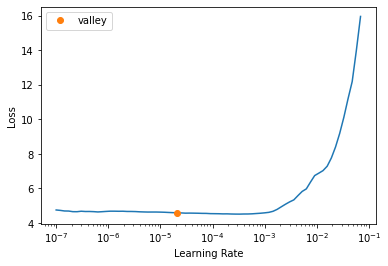

In [42]:
#gpt2 ouput is tuple, we need just one val
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]
        
        
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr = learn.lr_find()
print(lr)
learn.fit_one_cycle(5, lr)
# learn.fine_tune(3)

## 6. 학습된 모델 테스트

In [43]:
prompt="위치추적 전자장치(전자발찌) 훼손 전후로 여성 2명을 잇달아 살해한 "
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=128,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
tokenizer.decode(preds[0].cpu().numpy())

'위치추적 전자장치(전자발찌) 훼손 전후로 여성 2명을 잇달아 살해한 ”“그런데 왜 자꾸 이런 식으로 사람을 죽였어?” “자세한 건 모르겠지만... 살인범이 범행 후 도주하는 동안에도 계속 피해자를 노려봤을 거예요? 그게 바로 연쇄살인 사건이지요?” 「마지막 장」중에서나는 이 모든 것을 알고 있었다 나는 지금껏 내가 저지른 짓들을 모두 기억하고 있다 하지만 내 머릿속에는 여전히 나의 과거가 남아 있을 뿐이었다, 라고 생각했었지 그러나 이제부터 다시 생각해보면, 나 자신이 어떤 사람인지 알 수 없었'

## 7. 모델 저장

In [44]:
learn.model.save_pretrained("./model/Gen_novel_GPT2_model")

## 8. 모델 불러오기

In [15]:
load_model = AutoModelWithLMHead.from_pretrained("./model/Gen_novel_GPT2_model")
load_model.eval() # 가중치를 다시 계산하지 않기 위해서 실행
load_model = load_model.cuda() # gpu와 cpu 재할당

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
